# Klasyfikacja ręcznie rysowanych symboli
## Krok 1: Przygotowanie danych
Pobieramy dataset ze strony, jest tam 10 folderów, gdzie każdy to kolejny symbol.


In [1]:
import os

dataset_path = 'dataset'    # należy pobrać dataset ze strony i dodać go do repo, nie waży dużo
subfolders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

results = {}

for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    files = os.listdir(folder_path)
    
    total_files = len(files)
    digit_files = len([f for f in files if f.startswith('digit')])
    drawn_files = len([f for f in files if f.startswith('drawn')])
    stamp_files = len([f for f in files if f.startswith('stamp')])
    
    results[folder] = {
        'total': total_files,
        'digit': digit_files,
        'drawn': drawn_files,
        'stamp': stamp_files
    }

for folder, counts in results.items():
    print(f"Folder: {folder}")
    print(f"  Liczba wszystkich plików: {counts['total']}")
    print(f"  Pliki zaczynające się od 'digit': {counts['digit']}")
    print(f"  Pliki zaczynające się od 'drawn': {counts['drawn']}")
    print(f"  Pliki zaczynające się od 'stamp': {counts['stamp']}")
    print("-" * 20)

Folder: anchor
  Liczba wszystkich plików: 44
  Pliki zaczynające się od 'digit': 19
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 9
--------------------
Folder: balloon
  Liczba wszystkich plików: 43
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 9
--------------------
Folder: bicycle
  Liczba wszystkich plików: 44
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 10
--------------------
Folder: envelope
  Liczba wszystkich plików: 44
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 10
--------------------
Folder: paper_boat
  Liczba wszystkich plików: 42
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 8
--------------------
Folder: peace_symbol
  Liczba wszystkich plików: 43
  Pliki zaczynające się

Widzimy, że każda klasa ma w okolicach 43/44 zdjęć więc ich ilość równo rozłożona na klasy, podział na zdjęcia typu digit, stamp oraz drawn również jest podobny na przestrzeni wszystkich symboli co nie budzi wątpliwości, przyjrzyjmy się przykładowym zdjęciom:

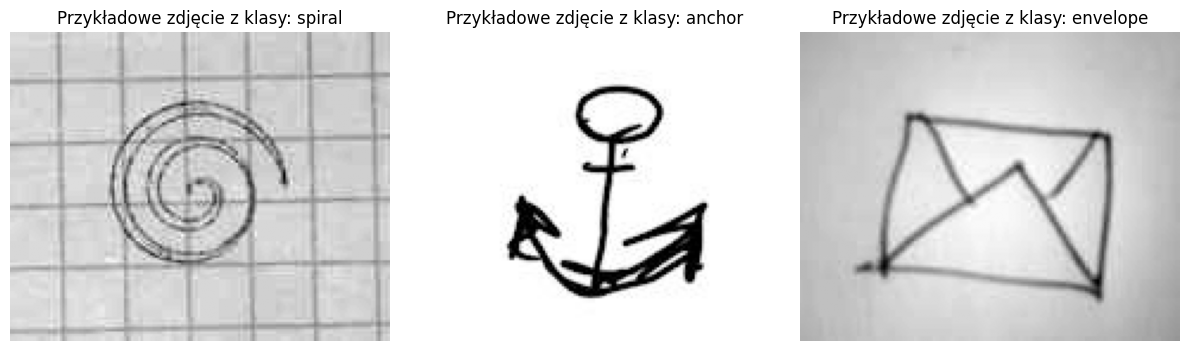

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
# wyświetlanie przykładowych obrazów z  datasetu
# Ścieżki do obrazów
image_paths = [
    'dataset/spiral/stamp05.jpg',
    'dataset/anchor/digit04.jpg',
    'dataset/envelope/drawn02.jpg'
]

# Tworzenie figury i osi
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Wyświetlanie każdego obrazu
for i, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert('L')
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Przykładowe zdjęcie z klasy: {img_path.split("/")[1]}')

plt.tight_layout()
plt.show()


 Najlepsze są zdjęcia robione komputerowo, posiadają mało szumów i przedstawiają faktyczne kształty symboli które chcemy wrzucać do modelu. Nie możemy powiedzieć tego samego o zdjęciach wykonanych przez człowieka, gdzie słabe oświetlenie i kartka w kratkę drastycznie pogarsza jakość obrazu, będziemy musieli się jakoś pozbyć tych szumów.

## Krok 2: Preprocessing
Testowałem kilka podejść, jak usunąć wszelkie cienie tudzież kratki ze zdjęć robionych ręcznie i najlepszy wynik otrzymałem po wykorzystaniu transformaty fouriera aby usuwać kratki ze zdjęć. Działa ona na zasadzie że wysokie zmiany w jasności są interpretowane jako wysoka częstotliwość, a niewielkie zmiany- jako niska, po czym przy dostrojeniu odpowiednich parametrów usuwamy te skoki częstotliwości gdzie występuje linia z zeszytu. Wiadomo, w pewnym stopniu może to też zaburzyć sam symbol i tak też w niektórych momentach się dzieje, ale uznałem że będzie to nienajgorszy kompromis. Po przepuszczeniu zdjęcia przez fouriera, dokonujemy binaryzacji, czyli na podstawie progu zamieniamy piksele w obrazie wyłącznie na kolor czarny i biały i po normalizacji do przedziału -1,1 nasze zdjęcia powinny być gotowe do uczenia.

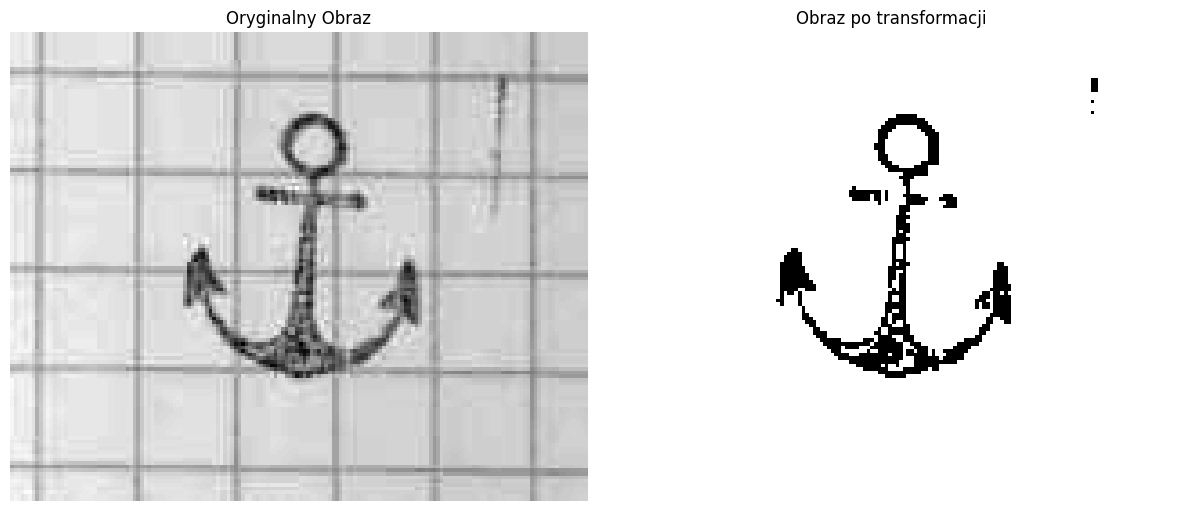

In [3]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

thresh = 99.3  # Próg procentowy do wykrywania pików
center_size = 15 # Rozmiar centralnego obszaru do ochrony

def remove_grid_fft(img):
    img_np = np.array(img.convert('L')) # kolor nie ma znaczenia, konwertujemy do skali szarości
    
    # transformacja fouriera
    f = np.fft.fft2(img_np)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    
    # Wykrywanie pików(lini kratki) jako lokalnych maksimów
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    local_max = cv2.dilate(magnitude_spectrum, kernel)
    peaks = (magnitude_spectrum == local_max)

    threshold = np.percentile(magnitude_spectrum, thresh)
    peaks &= (magnitude_spectrum > threshold)
    
    # Ochrona głównego kształtu (niskie częstotliwości)
    (rows, cols) = img_np.shape
    crow, ccol = rows // 2 , cols // 2
    peaks[crow-center_size:crow+center_size, ccol-center_size:ccol+center_size] = 0
    
    # usuwamy to co fft uznało za kratkę
    fshift[peaks] = 0.001
    
    # odwrotny fourier
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    
    img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return Image.fromarray(img_back)

# Ścieżka do obrazu
path = r'dataset/anchor/stamp03.jpg'

# Definicja transformacji
transform = transforms.Compose([
    transforms.Resize((130, 160)),  
    transforms.Lambda(remove_grid_fft),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()) # bez normalizacji bo chcemy tylko pokazac zdjecie
])

original_image = Image.open(path)

# Aplikowanie transformacji
transformed_tensor = transform(original_image)
image_to_show = transformed_tensor.squeeze()

# Wyświetlanie obrazów
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Oryginalny Obraz')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_to_show, cmap='gray')
plt.title('Obraz po transformacji')
plt.axis('off')

plt.tight_layout()
plt.show()



Zdjęcia lepszej jakości zostają w lepszym stanie ale główna idea przetwarzania zostaje taka sama.

## Krok3: ładowanie danych
przepuszczamy nasze dane przez wspomniane transformacje i ładujemy je do dataloadera, który będzie nam wypuszczaść dane do modelu w batchach. W tym miejscu dzielimy je na dane treningowe, testowe i walidacyjne, oraz dokonujemy augmentacji(przesunięcia, obroty itd) na zbiorze  treningowym dla lepszych wyników.

In [4]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

batch_size = 32
img_height = 130
img_width = 160
dataset_dir = 'dataset'

class SymbolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []
        
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        for cls_name in self.classes:
            class_dir = os.path.join(root_dir, cls_name)
            for file_name in os.listdir(class_dir):
                self.file_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def get_dataloaders(dataset_dir=dataset_dir, batch_size=batch_size, test_size=0.2, val_size=0.2):
    
    train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Lambda(remove_grid_fft),
    transforms.RandomAffine(degrees=20, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ElasticTransform(alpha=50.0, sigma=5.0),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()), 
    transforms.Normalize((0.5,), (0.5,))
])

    val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Lambda(remove_grid_fft),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),
    transforms.Normalize((0.5,), (0.5,))
])

    # Utworzenie pełnego zbioru danych
    full_dataset = SymbolDataset(root_dir=dataset_dir)
    
    # Podział na zbiór treningowo-walidacyjny i testowy
    indices = list(range(len(full_dataset)))
    labels = full_dataset.labels
    
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=labels, random_state=67
    )
    
    # Podział zbioru treningowo-walidacyjnego na treningowy i walidacyjny
    train_val_labels = [labels[i] for i in train_val_indices]
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_size, stratify=train_val_labels, random_state=42
    )

    
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)
    
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
   
    class_names = full_dataset.classes
    return train_loader, val_loader, test_loader, class_names



## Krok 4: Model
Do tego zadania użyłem modelu simple cnn, którego sieci konwolucyjne (te co przechodzą z filtrem przez zdjęcie) są przeznaczone do tego typu danych. Zdjęcia wydają się dosyć proste więc uznałem że mało skomplikowany układ będzie wystarczający (na przestrzeni tego projektu dużo rzeczy można usprawnić i dopracować ale ze względu na brak czasu w ostatnim czasie bardziej skupiłem się na ogólnej idei), i użyłem warstw conv2d oraz maxpool z funkcją aktywacji Relu, które są przeznaczone do rozpoznawania kształtów (to zadanie troche przypomina mnist) a maxpool redukuje wymiary aby finalnie przejść do jedynie 10 cech.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")
num_classes = 10

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Wyjście: (batch_size, 32, 65, 80)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Wyjście: (batch_size, 64, 32, 40)
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Wyjście: (batch_size, 128, 16, 20)
        )        
        
        # rozmiar obrazów na przestrzeni tworzenia kodu się zmieniał, adaptive pool zawsze sprowadza do tego samego rozmiaru
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7)) 
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),    # żeby nie overfitować odrzucamy 30% 
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)        
        x = self.classifier(x)
        return x

Używane urządzenie: cpu


## Krok 5: Przygotowanie modelu i pętla treningowa
skoro mamy już model, możemy przystąpić do pętli treningowej i ewaluacji. Jako optymalizator wybrałem Adama, a funkcją straty będzie entropia krzyżowa, czyli taki standard bym powiedział. Ogółem próbowałem dostosować hiperparametry przy użyciu optuny (optymalizator, lr , dropout itd.) ale zajmowało to niesamowicie dużo czasu, mój laptop nie był w stanie przerobić tego a wyniki z części obliczeń jakie zrobiłem nie były znaczące dla przebiegu uczenia, więc porzuciłem ten pomysł i pozostałem przy Adamie, lr ustawiłem na 0,001 a dropout na 0.5. Co do optymalizatorów jeszcze to SGD oraz AdamW dawały gorsze wyniki więc jest jak jest.

### Na początku zdefiniowałem funkcje do pojedyńczej epoki oraz ewaluacji

In [6]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):

    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion, device):

    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy, all_labels, all_preds

Mając to możemy już zrobić pętlę, na koniec też dodałem różne statystyki do analizy wyników uczenia. Liczbę epok dałem na 100, ale wprowadziłem też early stopping więc jak model osiągnie swój maksymalny potencjał wcześniej, to skończy wcześniej.

c:\Users\rondo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoka [1/100] | Strata treningowa: 2.3113, Dokładność treningowa: 0.1164 | Strata walidacyjna: 2.2418, Dokładność walidacyjna: 0.2319
Zapisano nowy najlepszy model z dokładnością: 0.2319
Epoka [2/100] | Strata treningowa: 2.1011, Dokładność treningowa: 0.2327 | Strata walidacyjna: 1.5877, Dokładność walidacyjna: 0.4348
Zapisano nowy najlepszy model z dokładnością: 0.4348
Epoka [2/100] | Strata treningowa: 2.1011, Dokładność treningowa: 0.2327 | Strata walidacyjna: 1.5877, Dokładność walidacyjna: 0.4348
Zapisano nowy najlepszy model z dokładnością: 0.4348
Epoka [3/100] | Strata treningowa: 1.5654, Dokładność treningowa: 0.4291 | Strata walidacyjna: 1.0913, Dokładność walidacyjna: 0.5797
Zapisano nowy najlepszy model z dokładnością: 0.5797
Epoka [3/100] | Strata treningowa: 1.5654, Dokładność treningowa: 0.4291 | Strata walidacyjna: 1.0913, Dokładność walidacyjna: 0.5797
Zapisano nowy najlepszy model z dokładnością: 0.5797
Epoka [4/100] | Strata treningowa: 1.2068, Dokładność treningowa:

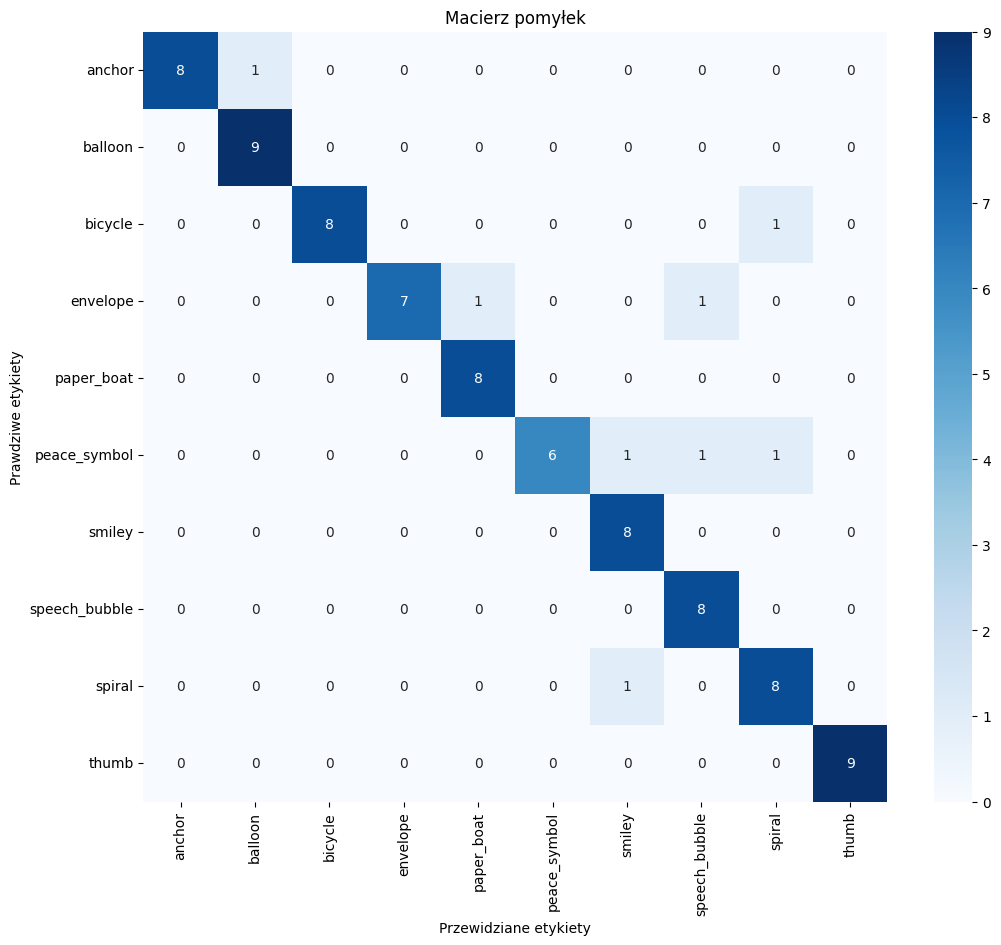

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

epochs = 100
patience = 10
learning_rate = 0.001

train_loader, val_loader, test_loader, class_names = get_dataloaders()

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)    
best_val_accuracy = 0.0
best_model_path = "best_model.pth"
epochs_no_improve = 0



# pętla treningowa
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _= evaluate(model, val_loader, criterion, device)
    
    print(f"Epoka [{epoch+1}/{epochs}] | "
            f"Strata treningowa: {train_loss:.4f}, Dokładność treningowa: {train_acc:.4f} | "
            f"Strata walidacyjna: {val_loss:.4f}, Dokładność walidacyjna: {val_acc:.4f}")

    # early stopping na najlepszym modelu
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Zapisano nowy najlepszy model z dokładnością: {best_val_accuracy:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience and epoch > 30: # niech zrobi co najmniej 30 epok za każdym razem
            print(f"\nEarly stopping, brak poprawy przez {patience} epok.")
            break


model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc, all_labels, all_preds = evaluate(model, test_loader, criterion, device)
print(f"\nOstateczna strata na zbiorze testowym: {test_loss:.4f}")
print(f"Ostateczna dokładność na zbiorze testowym: {test_acc:.4f}")

# --- Obliczanie i wyświetlanie macierzy pomyłek ---
cm = confusion_matrix(all_labels, all_preds)
print("\nMacierz pomyłek:")
print(cm)

# --- Obliczanie i wyświetlanie raportu klasyfikacji (w tym precyzji) ---
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nRaport klasyfikacji (precyzja, czułość, f1-score):")
print(report)

# --- Wizualizacja macierzy pomyłek ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Przewidziane etykiety')
plt.ylabel('Prawdziwe etykiety')
plt.title('Macierz pomyłek')
plt.show()

Ostateczna dokładność na zbiorze, który nie brał udziału w uczeniu wynosi nieco ponad 90% co nie jest najgorszym wynikiem. Macierz pomyłek pokazuje że na ogół model nauczył się klas dosyć dobrze (najgorzej poradził sobie z peace_symbol ale nie jest to drastyczny spadek) co można też zobaczyć w raporcie chociażby z precyzji, gdzie klasy znajdują się w przedzialie 80-100%, gdzie większość klas znajduje się w tej górnej połowie przedziału. Z tego co widzę, największy problem model ma z okrągłymi symbolami co możnaby uwzględnić przy poprawianiu modelu.

## Krok 6: Sprawdzenie modelu:
wykonałem 3 rysunki w paincie, oraz jeden pobrałem z internetu, zobaczmy czy wytrenowany model poprawnie klasyfikuje te zdjęcia

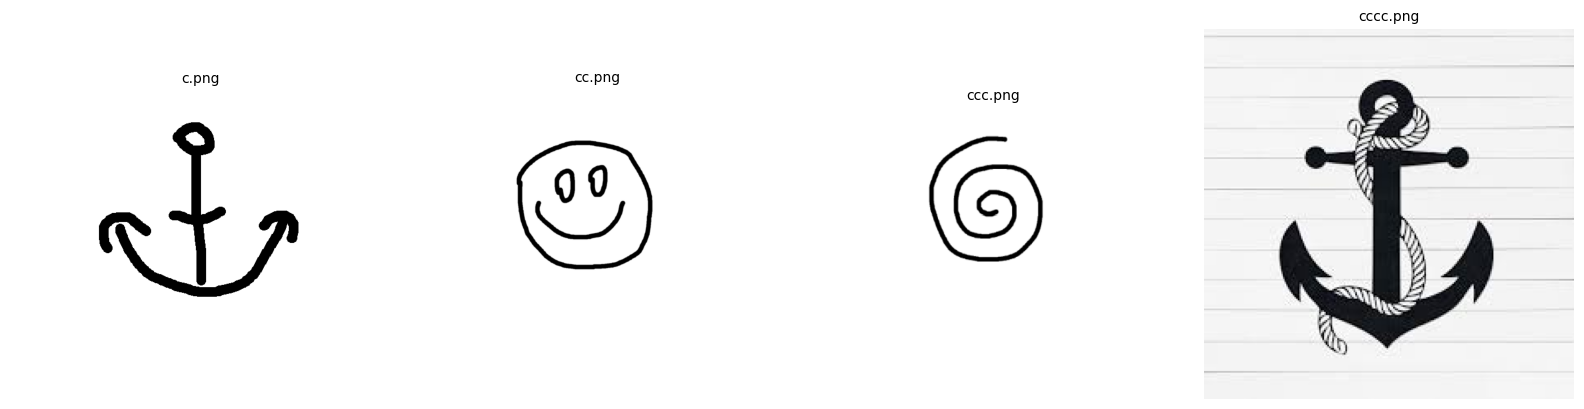

In [8]:
# wyświetlenie tych zdjęc z markdowna mi nie działało nwm dlaczego xddd
import os
import matplotlib.pyplot as plt
from PIL import Image

# Ścieżka do folderu z nowymi obrazkami
new_images_dir = 'new_images'


# Pobranie listy plików z obrazkami (tylko .png, .jpg, .jpeg)
image_files = sorted([f for f in os.listdir(new_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])


# Utworzenie siatki do wyświetlenia obrazków
num_images = len(image_files)
# Ustawienie rozmiaru figury dynamicznie
fig, axs = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

# Jeśli jest tylko jeden obrazek, axs nie jest listą, więc to naprawiamy
if num_images == 1:
    axs = [axs]

# Wyświetlenie każdego obrazka
for i, img_file in enumerate(image_files):
    img_path = os.path.join(new_images_dir, img_file)
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].set_title(img_file, fontsize=10)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

weźmy pod lupę tę kotwicę pobraną z internetu, na obrazku są poziome linie oraz dodatkowy  sznur wokół kotwicy więc ciekawe czy model rozpozna ten kształt

In [9]:
import torch
from torchvision import transforms
from PIL import Image

# Ścieżki
image_path = r"C:\Users\rondo\Desktop\PROJEKTY\Solvro-rekrutacja\new_images\cccc.png"
model_path = "best_model.pth"

# Transformacje
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Lambda(remove_grid_fft),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),
    transforms.Normalize((0.5,), (0.5,))
])

# pobieramy nazwy klas
temp_dataset = SymbolDataset(root_dir=dataset_dir)
class_names = temp_dataset.classes


def classify_image(image_path, model_path):
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(num_classes=num_classes).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() 

    img = Image.open(image_path).convert("L")
    transformed_img = transform(img)
    
    image_batch = transformed_img.unsqueeze(0).to(device)

    # Predykcja
    with torch.no_grad():
        output = model(image_batch)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_names[predicted_idx.item()]

    # wynik 
    print(f"\nModel przewidział klasę: '{predicted_class}'")


classify_image(image_path, model_path)




Model przewidział klasę: 'anchor'


Pomimo istniejącego na zdjęciu szumu mode poprawnie zgadł obiekt, reszta wyżej przedstawionych zdjęć również jest rozpoznawana poprawnie więc w pewnym stopniu model działa zgodznie z oczekiwaniami.

##  Wnioski:
W trakcie tworzenia modelu bardziej kierowałem się ideą niż wykręceniem najwyższego wyniku. Bardzo zależało mi na pozbyciu się kratek z zeszytów niestety kosztem niektórych zdjęć. Jak już wspominałem kombinowałem z optuną ale no na laptopie to szło tak topornie, że te hiperparametry wybrałem empirycznie, ogółem model wykręcił nie najgorszy wynik biorąc pod uwagę jak zaszumiony i mały był zbiór danych.
Możliwe że jeszcze coś ulepszę na przestrzeni tego tygodnia jak już wrócę do wrocławia (tęsknię za gpu)